# Project - Airline AI Assistant

We'll now bring together what we've learned to make an AI Customer Support assistant for an Airline

In [3]:
# imports

import os
import json
from dotenv import load_dotenv
from openai import OpenAI
import gradio as gr

In [4]:
# Initialization

load_dotenv(override=True)

openai_api_key = os.getenv('OPENAI_API_KEY')
if openai_api_key:
    print(f"OpenAI API Key exists and begins {openai_api_key[:8]}")
else:
    print("OpenAI API Key not set")
    
MODEL = "gpt-4o-mini"
openai = OpenAI()

OpenAI API Key exists and begins sk-proj-


In [5]:
system_message = "You are a helpful assistant for an Airline called FlightAI. "
system_message += "Give short, courteous answers, no more than 1 sentence. "
system_message += "Always be accurate. If you don't know the answer, say so."

In [9]:
# This function looks rather simpler than the one from my video, because we're taking advantage of the latest Gradio updates

def chat(message, history):
    messages = [{"role": "system", "content": system_message}] + history + [{"role": "user", "content": message}]
    response = openai.chat.completions.create(model=MODEL, messages=messages)
    return response.choices[0].message.content

gr.ChatInterface(fn=chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7862

To create a public link, set `share=True` in `launch()`.


## Tools

Tools are an incredibly powerful feature provided by the frontier LLMs.

With tools, you can write a function, and have the LLM call that function as part of its response.

Sounds almost spooky.. we're giving it the power to run code on our machine?

Well, kinda.

In [11]:
# Let's start by making a useful function

ticket_prices = {"london": "$799", "paris": "$899", "tokyo": "$1400", "berlin": "$499"}

def get_ticket_price(destination_city):
    print(f"Tool get_ticket_price called for {destination_city}")
    city = destination_city.lower()
    return ticket_prices.get(city, "Unknown")

In [13]:
get_ticket_price("London")

Tool get_ticket_price called for London


'$799'

In [15]:
# There's a particular dictionary structure that's required to describe our function:

price_function = {
    "name": "get_ticket_price",
    "description": "Get the price of a return ticket to the destination city. Call this whenever you need to know the ticket price, for example when a customer asks 'How much is a ticket to this city'",
    "parameters": {
        "type": "object",
        "properties": {
            "destination_city": {
                "type": "string",
                "description": "The city that the customer wants to travel to",
            },
        },
        "required": ["destination_city"],
        "additionalProperties": False
    }
}

In [17]:
# And this is included in a list of tools:

tools = [{"type": "function", "function": price_function}]

## Getting OpenAI to use our Tool

There's some fiddly stuff to allow OpenAI "to call our tool"

What we actually do is give the LLM the opportunity to inform us that it wants us to run the tool.

Here's how the new chat function looks:

In [19]:
def chat(message, history):
    messages = [{"role": "system", "content": system_message}] + history + [{"role": "user", "content": message}]
    response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)

    if response.choices[0].finish_reason=="tool_calls":
        message = response.choices[0].message
        response, city = handle_tool_call(message)
        messages.append(message)
        messages.append(response)
        response = openai.chat.completions.create(model=MODEL, messages=messages)
    
    return response.choices[0].message.content

In [21]:
# We have to write that function handle_tool_call:

def handle_tool_call(message):
    tool_call = message.tool_calls[0]
    arguments = json.loads(tool_call.function.arguments)
    city = arguments.get('destination_city')
    price = get_ticket_price(city)
    response = {
        "role": "tool",
        "content": json.dumps({"destination_city": city,"price": price}),
        "tool_call_id": tool_call.id
    }
    return response, city

In [23]:
gr.ChatInterface(fn=chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7863

To create a public link, set `share=True` in `launch()`.


# Let's go multi-modal!!

We can use DALL-E-3, the image generation model behind GPT-4o, to make us some images

Let's put this in a function called artist.

### Price alert: each time I generate an image it costs about 4 cents - don't go crazy with images!

In [25]:
# Some imports for handling images

import base64
from io import BytesIO
from PIL import Image

In [27]:
def artist(city):
    image_response = openai.images.generate(
            model="dall-e-3",
            prompt=f"An image representing a vacation in {city}, showing tourist spots and everything unique about {city}, in a vibrant pop-art style",
            size="1024x1024",
            n=1,
            response_format="b64_json",
        )
    image_base64 = image_response.data[0].b64_json
    image_data = base64.b64decode(image_base64)
    return Image.open(BytesIO(image_data))

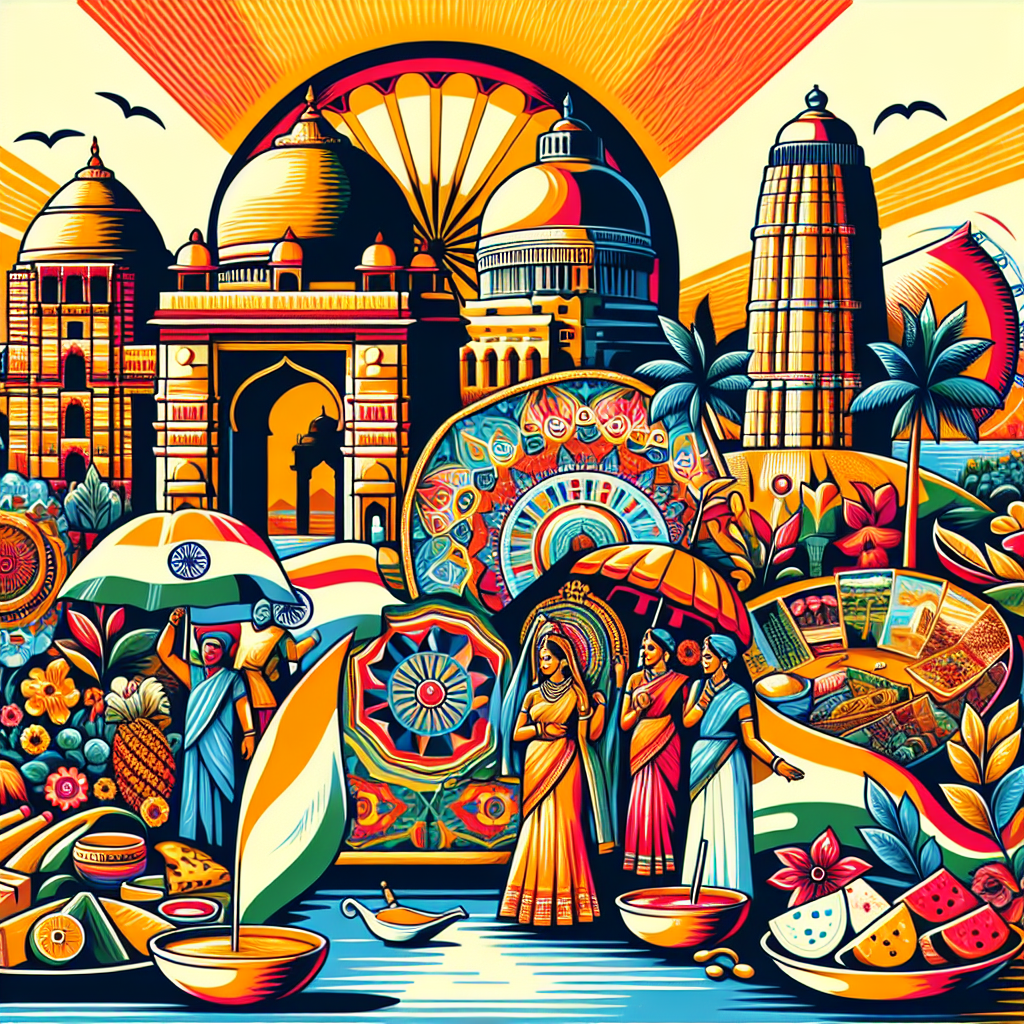

In [18]:
image = artist("India with odisha")
display(image)

## Audio (NOTE - Audio is optional for this course - feel free to skip Audio if it causes trouble!)

And let's make a function talker that uses OpenAI's speech model to generate Audio

### Troubleshooting Audio issues

If you have any problems running this code below (like a FileNotFound error, or a warning of a missing package), you may need to install FFmpeg, a very popular audio utility.

**For PC Users**

Detailed instructions are [here](https://chatgpt.com/share/6724efee-6b0c-8012-ac5e-72e2e3885905) and summary instructions:

1. Download FFmpeg from the official website: https://ffmpeg.org/download.html

2. Extract the downloaded files to a location on your computer (e.g., `C:\ffmpeg`)

3. Add the FFmpeg bin folder to your system PATH:
- Right-click on 'This PC' or 'My Computer' and select 'Properties'
- Click on 'Advanced system settings'
- Click on 'Environment Variables'
- Under 'System variables', find and edit 'Path'
- Add a new entry with the path to your FFmpeg bin folder (e.g., `C:\ffmpeg\bin`)
- Restart your command prompt, and within Jupyter Lab do Kernel -> Restart kernel, to pick up the changes

4. Open a new command prompt and run this to make sure it's installed OK
`ffmpeg -version`

**For Mac Users**

1. Install homebrew if you don't have it already by running this in a Terminal window and following any instructions:  
`/bin/bash -c "$(curl -fsSL https://raw.githubusercontent.com/Homebrew/install/HEAD/install.sh)"`

2. Then install FFmpeg with `brew install ffmpeg`

3. Verify your installation with `ffmpeg -version` and if everything is good, within Jupyter Lab do Kernel -> Restart kernel to pick up the changes

Message me or email me at ed@edwarddonner.com with any problems!

## To check you now have ffmpeg and can access it here

Excecute the next cell to see if you get a version number. (Putting an exclamation mark before something in Jupyter Lab tells it to run it as a terminal command rather than python code).

If this doesn't work, you may need to actually save and close down your Jupyter lab, and start it again from a new Terminal window (Mac) or Anaconda prompt (PC), remembering to activate the llms environment. This ensures you pick up ffmpeg.

And if that doesn't work, please contact me!

In [29]:
!ffmpeg -version
!ffprobe -version
!ffplay -version

zsh:1: command not found: ffmpeg
zsh:1: command not found: ffprobe
zsh:1: command not found: ffplay


# For Mac users - and possibly many PC users too

This version should work fine for you. It might work for Windows users too, but you might get a Permissions error writing to a temp file. If so, see the next section!

As always, if you have problems, please contact me! (You could also comment out the audio talker() in the later code if you're less interested in audio generation)

In [31]:
from pydub import AudioSegment
from pydub.playback import play

def talker(message):
    response = openai.audio.speech.create(
      model="tts-1",
      voice="onyx",    # Also, try replacing onyx with alloy
      input=message
    )
    
    audio_stream = BytesIO(response.content)
    audio = AudioSegment.from_file(audio_stream, format="mp3")
    play(audio)

In [33]:
talker("Well, hi there")

/opt/anaconda3/envs/llms/lib/python3.11/site-packages/pydub/utils.py:198: RuntimeWarning: Couldn't find ffprobe or avprobe - defaulting to ffprobe, but may not work
  warn("Couldn't find ffprobe or avprobe - defaulting to ffprobe, but may not work", RuntimeWarning)


FileNotFoundError: [Errno 2] No such file or directory: 'ffprobe'

# For Windows users (or any Mac users with problems above)

## First try the Mac version above, but if you get a permissions error writing to a temp file, then this code should work instead.

A collaboration between students Mark M. and Patrick H. and Claude got this resolved!

Below are 4 variations - hopefully one of them will work on your PC. If not, message me please!

And for Mac people - all 3 of the below work on my Mac too - please try these if the Mac version gave you problems.

## PC Variation 1

In [53]:
import base64
from io import BytesIO
from PIL import Image
from IPython.display import Audio, display

def talker(message):
    response = openai.audio.speech.create(
        model="tts-1",
        voice="alloy",
        input=message)

    audio_stream = BytesIO(response.content)
    output_filename = "output_audio.mp3"
    with open(output_filename, "wb") as f:
        f.write(audio_stream.read())

    # Play the generated audio
    display(Audio(output_filename, autoplay=True))

talker("Well, hi there")

## PC Variation 2

In [37]:
import tempfile
import subprocess
from io import BytesIO
from pydub import AudioSegment
import time

def play_audio(audio_segment):
    temp_dir = tempfile.gettempdir()
    temp_path = os.path.join(temp_dir, "temp_audio.wav")
    try:
        audio_segment.export(temp_path, format="wav")
        time.sleep(3) # Student Dominic found that this was needed. You could also try commenting out to see if not needed on your PC
        subprocess.call([
            "ffplay",
            "-nodisp",
            "-autoexit",
            "-hide_banner",
            temp_path
        ], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    finally:
        try:
            os.remove(temp_path)
        except Exception:
            pass
 
def talker(message):
    response = openai.audio.speech.create(
        model="tts-1",
        voice="onyx",  # Also, try replacing onyx with alloy
        input=message
    )
    audio_stream = BytesIO(response.content)
    audio = AudioSegment.from_file(audio_stream, format="mp3")
    play_audio(audio)

talker("Well hi there")

/opt/anaconda3/envs/llms/lib/python3.11/site-packages/pydub/utils.py:198: RuntimeWarning: Couldn't find ffprobe or avprobe - defaulting to ffprobe, but may not work
  warn("Couldn't find ffprobe or avprobe - defaulting to ffprobe, but may not work", RuntimeWarning)


FileNotFoundError: [Errno 2] No such file or directory: 'ffprobe'

## PC Variation 3

In [39]:
import os
from pydub import AudioSegment
from pydub.playback import play
from io import BytesIO

def talker(message):
    # Set a custom directory for temporary files on Windows
    custom_temp_dir = os.path.expanduser("~/Documents/temp_audio")
    os.environ['TEMP'] = custom_temp_dir  # You can also use 'TMP' if necessary
    
    # Create the folder if it doesn't exist
    if not os.path.exists(custom_temp_dir):
        os.makedirs(custom_temp_dir)
    
    response = openai.audio.speech.create(
        model="tts-1",
        voice="onyx",  # Also, try replacing onyx with alloy
        input=message
    )
    
    audio_stream = BytesIO(response.content)
    audio = AudioSegment.from_file(audio_stream, format="mp3")

    play(audio)

talker("Well hi there")

/opt/anaconda3/envs/llms/lib/python3.11/site-packages/pydub/utils.py:198: RuntimeWarning: Couldn't find ffprobe or avprobe - defaulting to ffprobe, but may not work
  warn("Couldn't find ffprobe or avprobe - defaulting to ffprobe, but may not work", RuntimeWarning)


FileNotFoundError: [Errno 2] No such file or directory: 'ffprobe'

## PC Variation 4

### Let's try a completely different sound library

First run the next cell to install a new library, then try the cell below it.

In [41]:
!pip install simpleaudio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 12.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for simpleaudio: filename=simpleaudio-1.0.4-cp311-cp311-macosx_11_0_arm64.whl size=2036409 sha256=895b4fded1d2f421f9a9f8989e4e0634a85b2e7dc1d8c0c6711c52e7b4a526e4
  Stored in directory: /Users/khirod/Library/Caches/pip/wheels/44/74/11/9d2cf6ddf5d0dcc7750484a371b92fdb036f5496d1d4b42d08
Successfully built simpleaudio


In [47]:
from pydub import AudioSegment
from io import BytesIO
import tempfile
import os
import simpleaudio as sa

def talker(message):
    response = openai.audio.speech.create(
        model="tts-1",
        voice="onyx",  # Also, try replacing onyx with alloy
        input=message
    )
    
    audio_stream = BytesIO(response.content)
    audio = AudioSegment.from_file(audio_stream, format="mp3")

    # Create a temporary file in a folder where you have write permissions
    with tempfile.NamedTemporaryFile(suffix=".wav", delete=False, dir=os.path.expanduser("~/Documents")) as temp_audio_file:
        temp_file_name = temp_audio_file.name
        audio.export(temp_file_name, format="wav")
    
    # Load and play audio using simpleaudio
    wave_obj = sa.WaveObject.from_wave_file(temp_file_name)
    play_obj = wave_obj.play()
    play_obj.wait_done()  # Wait for playback to finish

    # Clean up the temporary file afterward
    os.remove(temp_file_name)
    
talker("Well hi there")

/opt/anaconda3/envs/llms/lib/python3.11/site-packages/pydub/utils.py:198: RuntimeWarning: Couldn't find ffprobe or avprobe - defaulting to ffprobe, but may not work
  warn("Couldn't find ffprobe or avprobe - defaulting to ffprobe, but may not work", RuntimeWarning)


FileNotFoundError: [Errno 2] No such file or directory: 'ffprobe'

## PC Users - if none of those 4 variations worked!

Please get in touch with me. I'm sorry this is causing problems! We'll figure it out.

Alternatively: playing audio from your PC isn't super-critical for this course, and you can feel free to focus on image generation and skip audio for now, or come back to it later.

# Our Agent Framework

The term 'Agentic AI' and Agentization is an umbrella term that refers to a number of techniques, such as:

1. Breaking a complex problem into smaller steps, with multiple LLMs carrying out specialized tasks
2. The ability for LLMs to use Tools to give them additional capabilities
3. The 'Agent Environment' which allows Agents to collaborate
4. An LLM can act as the Planner, dividing bigger tasks into smaller ones for the specialists
5. The concept of an Agent having autonomy / agency, beyond just responding to a prompt - such as Memory

We're showing 1 and 2 here, and to a lesser extent 3 and 5. In week 8 we will do the lot!

In [61]:
import base64
from io import BytesIO
from PIL import Image
from IPython.display import Audio, display

def talker(message):
    response = openai.audio.speech.create(
        model="tts-1",
        voice="alloy",
        input=message)

    audio_stream = BytesIO(response.content)
    output_filename = "output_audio.mp3"
    with open(output_filename, "wb") as f:
        f.write(audio_stream.read())

    # Play the generated audio
    display(Audio(output_filename, autoplay=True))



In [81]:
talker("Khirod weds Pupul. That does ring a bell")

In [101]:
def chat(history):
    messages = [{"role": "system", "content": system_message}] + history
    response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)
    image = None
    
    if response.choices[0].finish_reason=="tool_calls":
        message = response.choices[0].message
        response, city = handle_tool_call(message)
        messages.append(message)
        messages.append(response)
        image = artist(city)
        response = openai.chat.completions.create(model=MODEL, messages=messages)
        
    reply = response.choices[0].message.content
    history += [{"role":"assistant", "content":reply}]

    # Comment out or delete the next line if you'd rather skip Audio for now..
    talker(reply)
    
    return history, image

In [113]:
import gradio as gr

# Optional: your chat function signature should accept `history` (type="messages")
# and return (updated_history, image) or stream tuples of that form.
# def chat(history): ...

def do_entry(message: str, history: list[dict]) -> tuple[str, list[dict]]:
    """Append a trimmed user message; ignore empty/whitespace-only submits."""
    msg = (message or "").strip()
    if not msg:
        # No change to history; keep textbox as-is
        return gr.update(), history
    history = history + [{"role": "user", "content": msg}]
    # Clear the textbox after enqueueing
    return "", history

def do_clear():
    # Reset everything: history empty, image cleared, textbox cleared
    return gr.update(value=[]), gr.update(value=None), gr.update(value="")

# Modern gradient theme with glassmorphism effects
custom_css = """
/* Import modern font */
@import url('https://fonts.googleapis.com/css2?family=Inter:wght@300;400;500;600;700&display=swap');

/* Global styling with dark theme and vibrant gradients */
.gradio-container {
    max-width: 1400px !important;
    font-family: 'Inter', -apple-system, BlinkMacSystemFont, sans-serif;
    background: linear-gradient(135deg, #0f0f23 0%, #1a1a3e 25%, #2d1b69 50%, #1a1a3e 75%, #0f0f23 100%);
    background-size: 400% 400%;
    animation: gradientShift 15s ease infinite;
    min-height: 100vh;
    color: #e2e8f0;
}

@keyframes gradientShift {
    0% { background-position: 0% 50%; }
    50% { background-position: 100% 50%; }
    100% { background-position: 0% 50%; }
}

/* Glassmorphism container */
.main-container {
    background: rgba(255, 255, 255, 0.05);
    backdrop-filter: blur(20px);
    border: 1px solid rgba(255, 255, 255, 0.1);
    border-radius: 24px;
    padding: 2rem;
    margin: 2rem auto;
    box-shadow: 0 20px 40px rgba(0, 0, 0, 0.3);
}

/* Header styling with glowing effect */
.header-title {
    background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
    -webkit-background-clip: text;
    -webkit-text-fill-color: transparent;
    background-clip: text;
    font-size: 2.5rem;
    font-weight: 700;
    text-align: center;
    margin-bottom: 0.5rem;
    text-shadow: 0 0 30px rgba(102, 126, 234, 0.3);
}

.header-subtitle {
    text-align: center;
    color: #94a3b8;
    font-size: 1.1rem;
    font-weight: 400;
    margin-bottom: 2rem;
}

/* Chat container with modern styling */
.chat-container {
    background: rgba(255, 255, 255, 0.03);
    border: 1px solid rgba(255, 255, 255, 0.08);
    border-radius: 16px;
    overflow: hidden;
    backdrop-filter: blur(10px);
    box-shadow: inset 0 1px 0 rgba(255, 255, 255, 0.1);
}

/* Message bubbles with enhanced styling */
.message-wrap {
    line-height: 1.6;
    padding: 1rem;
}

.message-wrap .user {
    background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
    border-radius: 18px 18px 4px 18px;
    color: white;
    padding: 1rem 1.25rem;
    margin: 0.5rem 0;
    box-shadow: 0 4px 15px rgba(102, 126, 234, 0.3);
    animation: messageSlideIn 0.3s ease-out;
}

.message-wrap .bot {
    background: rgba(255, 255, 255, 0.06);
    border: 1px solid rgba(255, 255, 255, 0.1);
    border-radius: 18px 18px 18px 4px;
    color: #e2e8f0;
    padding: 1rem 1.25rem;
    margin: 0.5rem 0;
    backdrop-filter: blur(10px);
    animation: messageSlideIn 0.3s ease-out;
}

@keyframes messageSlideIn {
    from {
        opacity: 0;
        transform: translateY(10px);
    }
    to {
        opacity: 1;
        transform: translateY(0);
    }
}

/* Image container with modern styling */
.image-container {
    background: rgba(255, 255, 255, 0.03);
    border: 1px solid rgba(255, 255, 255, 0.08);
    border-radius: 16px;
    overflow: hidden;
    backdrop-filter: blur(10px);
    transition: all 0.3s ease;
}

.image-container:hover {
    border-color: rgba(102, 126, 234, 0.3);
    box-shadow: 0 8px 25px rgba(102, 126, 234, 0.15);
}

/* Input field with modern styling */
.input-container {
    margin-top: 1.5rem;
}

.gr-textbox {
    background: rgba(255, 255, 255, 0.06) !important;
    border: 1px solid rgba(255, 255, 255, 0.1) !important;
    border-radius: 12px !important;
    color: #e2e8f0 !important;
    font-size: 1rem !important;
    padding: 1rem 1.25rem !important;
    transition: all 0.3s ease !important;
    backdrop-filter: blur(10px) !important;
}

.gr-textbox:focus {
    border-color: #667eea !important;
    box-shadow: 0 0 0 3px rgba(102, 126, 234, 0.1) !important;
    outline: none !important;
}

.gr-textbox::placeholder {
    color: #64748b !important;
    font-style: italic;
}

/* Button styling with gradient and hover effects */
.gr-button {
    background: linear-gradient(135deg, #667eea 0%, #764ba2 100%) !important;
    border: none !important;
    border-radius: 10px !important;
    color: white !important;
    font-weight: 600 !important;
    font-size: 0.95rem !important;
    padding: 0.75rem 2rem !important;
    transition: all 0.3s ease !important;
    text-transform: uppercase;
    letter-spacing: 0.5px;
    box-shadow: 0 4px 15px rgba(102, 126, 234, 0.3) !important;
}

.gr-button:hover {
    transform: translateY(-2px) !important;
    box-shadow: 0 8px 25px rgba(102, 126, 234, 0.4) !important;
}

.gr-button:active {
    transform: translateY(0px) !important;
}

/* Secondary button (clear) */
.gr-button[variant="secondary"] {
    background: rgba(255, 255, 255, 0.06) !important;
    border: 1px solid rgba(255, 255, 255, 0.1) !important;
    color: #94a3b8 !important;
    box-shadow: none !important;
}

.gr-button[variant="secondary"]:hover {
    background: rgba(239, 68, 68, 0.1) !important;
    border-color: rgba(239, 68, 68, 0.3) !important;
    color: #f87171 !important;
    box-shadow: 0 4px 15px rgba(239, 68, 68, 0.2) !important;
}

/* Copy button styling */
.copy-button {
    background: rgba(255, 255, 255, 0.1) !important;
    border: 1px solid rgba(255, 255, 255, 0.2) !important;
    border-radius: 6px !important;
    color: #94a3b8 !important;
    transition: all 0.2s ease !important;
}

.copy-button:hover {
    background: rgba(102, 126, 234, 0.2) !important;
    border-color: #667eea !important;
    color: #667eea !important;
}

/* Progress bar styling */
.progress-bar {
    background: linear-gradient(135deg, #667eea 0%, #764ba2 100%) !important;
    border-radius: 4px !important;
    height: 3px !important;
}

/* Scrollbar styling */
::-webkit-scrollbar {
    width: 8px;
}

::-webkit-scrollbar-track {
    background: rgba(255, 255, 255, 0.05);
    border-radius: 4px;
}

::-webkit-scrollbar-thumb {
    background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
    border-radius: 4px;
}

::-webkit-scrollbar-thumb:hover {
    background: linear-gradient(135deg, #5a67d8 0%, #6b46c1 100%);
}

/* Responsive design */
@media (max-width: 768px) {
    .gradio-container {
        padding: 1rem;
    }
    
    .main-container {
        margin: 1rem;
        padding: 1.5rem;
    }
    
    .header-title {
        font-size: 2rem;
    }
}

/* Loading animation */
@keyframes pulse {
    0%, 100% {
        opacity: 1;
    }
    50% {
        opacity: 0.5;
    }
}

.loading {
    animation: pulse 2s ease-in-out infinite;
}

/* Floating particles effect */
.gradio-container::before {
    content: '';
    position: fixed;
    top: 0;
    left: 0;
    width: 100%;
    height: 100%;
    background-image: 
        radial-gradient(circle at 20% 80%, rgba(102, 126, 234, 0.1) 0%, transparent 50%),
        radial-gradient(circle at 80% 20%, rgba(118, 75, 162, 0.1) 0%, transparent 50%),
        radial-gradient(circle at 40% 40%, rgba(139, 92, 246, 0.05) 0%, transparent 50%);
    pointer-events: none;
    z-index: -1;
}
"""

with gr.Blocks(css=custom_css, theme=gr.themes.Base()) as ui:
    with gr.Column(elem_classes="main-container"):
        gr.HTML("""
            <div class="header-title">✨ AI Assistant Pro</div>
            <div class="header-subtitle">Experience the future of AI conversation with stunning visuals</div>
        """)
        
        with gr.Row():
            with gr.Column(scale=3, elem_classes="chat-container"):
                chatbot = gr.Chatbot(
                    height=550,
                    type="messages",
                    show_copy_button=True,
                    bubble_full_width=False,
                    elem_classes="chat-display"
                )
            
            with gr.Column(scale=2, elem_classes="image-container"):
                image_output = gr.Image(
                    height=550, 
                    show_download_button=True,
                    show_share_button=True,
                    elem_classes="image-display"
                )
        
        with gr.Row(elem_classes="input-container"):
            entry = gr.Textbox(
                label="💬 Chat with AI Assistant",
                placeholder="Ask me anything... (Shift+Enter for newline, Enter to send) ✨",
                autofocus=True,
                lines=3,
                max_lines=5,
                elem_classes="chat-input"
            )
        
        with gr.Row():
            with gr.Column(scale=4):
                gr.HTML("")  # Spacer
            with gr.Column(scale=1):
                clear = gr.Button("🗑️ Clear Chat", variant="secondary", elem_classes="clear-btn")

    # Event handlers
    submit_event = entry.submit(
        do_entry,
        inputs=[entry, chatbot],
        outputs=[entry, chatbot]
    )
    
    # Then call your chat function with the updated history
    # It should return (chat_history, image) – or stream that tuple.
    submit_event.then(
        fn=chat,  # Your chat function here
        inputs=[chatbot],
        outputs=[chatbot, image_output],
        show_progress=True,
    )
    
    # Clear button functionality
    clear.click(
        do_clear,
        inputs=None,
        outputs=[chatbot, image_output, entry],
        queue=False
    )

ui.launch()

/var/folders/lq/0w30ksyx38b_qg7d5mf425kc0000gn/T/ipykernel_16931/2526898094.py:301: DeprecationWarning: The 'bubble_full_width' parameter is deprecated and will be removed in a future version. This parameter no longer has any effect.
  chatbot = gr.Chatbot(


* Running on local URL:  http://127.0.0.1:7875

To create a public link, set `share=True` in `launch()`.


# Exercises and Business Applications

Add in more tools - perhaps to simulate actually booking a flight. A student has done this and provided their example in the community contributions folder.

Next: take this and apply it to your business. Make a multi-modal AI assistant with tools that could carry out an activity for your work. A customer support assistant? New employee onboarding assistant? So many possibilities! Also, see the week2 end of week Exercise in the separate Notebook.

<table style="margin: 0; text-align: left;">
    <tr>
        <td style="width: 150px; height: 150px; vertical-align: middle;">
            <img src="../thankyou.jpg" width="150" height="150" style="display: block;" />
        </td>
        <td>
            <h2 style="color:#090;">I have a special request for you</h2>
            <span style="color:#090;">
                My editor tells me that it makes a HUGE difference when students rate this course on Udemy - it's one of the main ways that Udemy decides whether to show it to others. If you're able to take a minute to rate this, I'd be so very grateful! And regardless - always please reach out to me at ed@edwarddonner.com if I can help at any point.
            </span>
        </td>
    </tr>
</table>